# Upper Grindelwald case study

### Imports

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm as colormap
from matplotlib import transforms
import matplotlib.colors as colors
%matplotlib inline
fig_size = 8, 8
plt.rcParams['figure.figsize'] = (fig_size)  # Default plot size

import numpy as np
import pandas as pd
import netCDF4
import salem

In [2]:
import oggm
from oggm import cfg
from oggm import workflow
from oggm import utils
from oggm import graphics
from oggm.core.models import massbalance, flowline

In [3]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [4]:
cfg.initialize()  # read the default parameter file for OGGM

### Glacier directory

In [5]:
bdir = '/Users/oberrauch/bac/raw_data/grindelwald/'  # Put your path here
gdir = utils.GlacierDirectory('RGI50-11.01270', base_dir=bdir)

In [6]:
flowline.init_present_time_glacier(gdir)

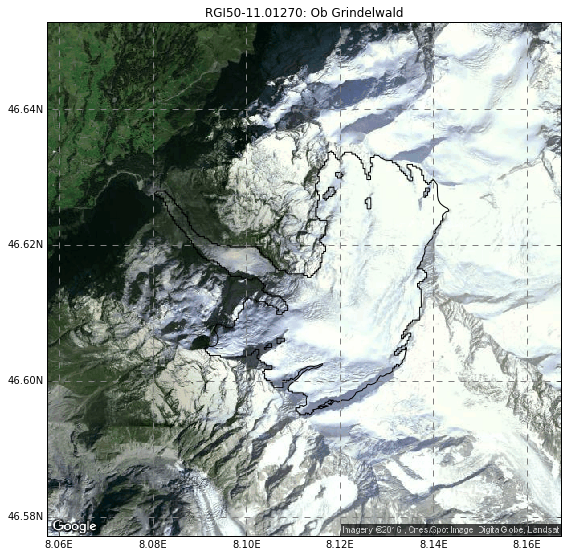

In [7]:
graphics.plot_googlemap(gdir)

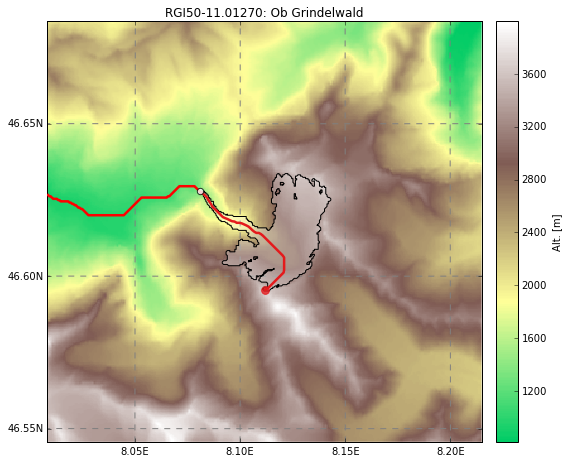

In [8]:
graphics.plot_centerlines(gdir, use_flowlines=True, add_downstream=True)

In [25]:
print(cfg.PATHS)

OrderedDict([('working_dir', '/Users/oberrauch/OGGM_wd'), ('topo_dir', '~'), ('cru_dir', '~'), ('rgi_dir', '~'), ('dem_file', '~'), ('climate_file', '~'), ('wgms_rgi_links', '~'), ('glathida_rgi_links', '~'), ('leclercq_rgi_links', '~')])


In [26]:
print('Directory containing the glacier data:', gdir.dir)
print('RGI identifier:', gdir.rgi_id)
print('RGI outline date:', gdir.rgi_date)
print('RGI glacier area in km2:', gdir.rgi_area_km2)
print('OGGM glacier grid size in m:', gdir.grid.dx)

Directory containing the glacier data: /Users/oberrauch/bac/raw_data/grindelwald/RGI50-11.01270
RGI identifier: RGI50-11.01270
RGI outline date: 2003-07-01 00:00:00
RGI glacier area in km2: 9.023
OGGM glacier grid size in m: 46.0


In [27]:
gdir.get_filepath('dem')

'/Users/oberrauch/bac/raw_data/grindelwald/RGI50-11.01270/dem.tif'

### Example: see how well the flowline represents the altitude area distribution of the glacier

In [28]:
# Local topography data
fgrid = gdir.get_filepath('gridded_data')
with netCDF4.Dataset(fgrid) as nc:
    topo = nc.variables['topo_smoothed'][:]
    mask = nc.variables['glacier_mask'][:]
    outline = nc.variables['glacier_ext'][:]

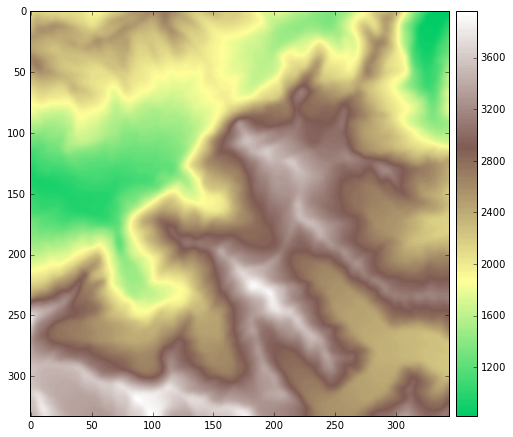

In [29]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

cm = truncate_colormap(colormap.terrain, minval=0.25, maxval=1.0, n=256)
plt.imshow(topo, cmap=cm)

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

plt.colorbar(cax=cax)

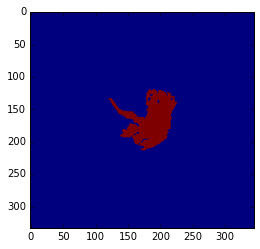

In [76]:
plt.figure(figsize=(4, 4))
plt.imshow(mask)

In [36]:
# histogram of real glacier
bins = np.arange(1400, 3601, 100)
hist_real, _ = np.histogram(topo[np.nonzero(mask)], bins=bins, density=True)

In [51]:
# Histogram of flowline glacier
fl = gdir.read_pickle('inversion_flowlines')[-1]  # -1 because there is just one flowline
hist, _ = np.histogram(fl.surface_h, weights=fl.widths, bins=bins, density=True)

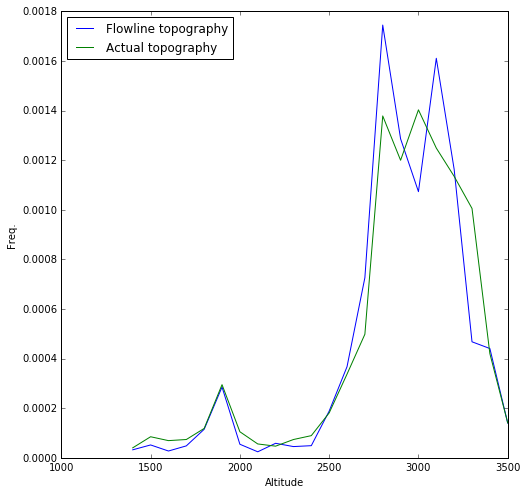

In [52]:
# Plot
plt.plot(bins[:-1], hist, label='Flowline topography')
plt.plot(bins[:-1], hist_real, label='Actual topography')
plt.ylabel('Freq.');
plt.xlabel('Altitude');
plt.legend(loc='best');

### Example: mass-balance data

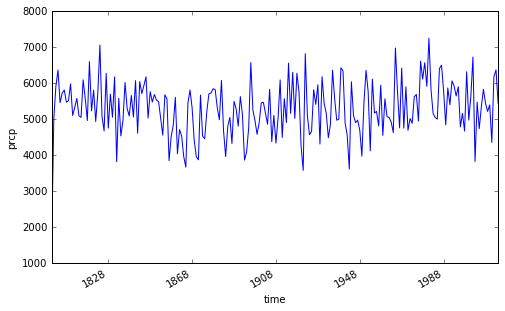

In [75]:
import xarray as xr
d = xr.open_dataset(gdir.get_filepath('climate_monthly'))
plt.figure(figsize=(8, 5))
d.prcp.resample(freq='AS', dim='time', how=np.sum).plot()

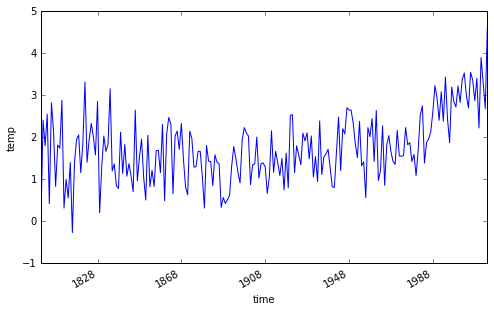

In [74]:
plt.figure(figsize=(8, 5))
d.temp.resample(freq='AS', dim='time', how=np.mean).plot()

In [55]:
# t_Star = year at which Grindelwald was in equi, according to oggr. mu_star is temperature sensitivity
pd.read_csv(gdir.get_filepath('local_mustar'))

,rgi_id,t_star,mu_star,bias
0,RGI50-11.01270,1975,355.738294,-16.973493


In [56]:
# We can build a mass-balance model based on these values and climate from HISTALP
mbmod = massbalance.HistalpMassBalanceModel(gdir)

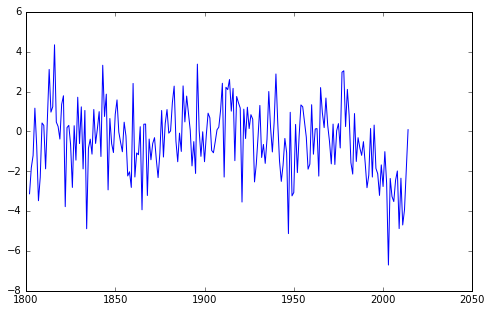

In [73]:
years = np.arange(1802, 2015, 1)
spec_mb = years * 0.
for i, y in enumerate(years):
    mb_onh = mbmod.get_mb(fl.surface_h, year=y) * oggm.cfg.SEC_IN_YEAR
    spec_mb[i] = np.average(mb_onh, weights=fl.widths)  
plt.figure(figsize=(8, 5))
plt.plot(years, spec_mb)

In [1]:
# Check that mass balance around 1975 is approx zero
np.mean(spec_mb[np.nonzero((years >= 1960) & (years <= 1990))])

NameError: name 'np' is not defined

### Example: compute the bed thickness

In [63]:
from oggm.core.preprocessing.inversion import invert_parabolic_bed

In [64]:
glen_a = cfg.A
vol_m3, area_m3 = invert_parabolic_bed(gdir, glen_a=glen_a)
print('With the default A (={}), the mean thickness of Grindelwald is {:.1f} m'.format(glen_a, vol_m3/area_m3))

With the default A (=2.4e-24), the mean thickness of Grindelwald is 60.3 m


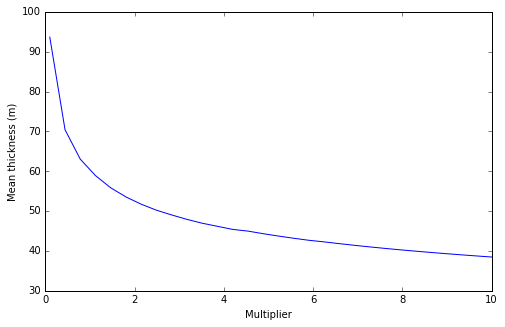

In [71]:
factor = np.linspace(0.1, 10, 30)
thick = factor*0
for i, f in enumerate(factor):
    vol_m3, area_m3 = invert_parabolic_bed(gdir, glen_a=glen_a*f)
    thick[i] = vol_m3/area_m3
plt.figure(figsize=(8, 5))
plt.plot(factor, thick);
plt.ylabel('Mean thickness (m)');
plt.xlabel('Multiplier');

Explain why it looks like this!

### Try to find out which points corresponds to the location of the GPR measurements (more or less)

Approximate lon, lat of measurements:

In [66]:
lat_ref, lon_ref = 46.617991, 8.098331

Lon, lat along the flowline and closest point (index):

In [67]:
gi, gj = fl.line.xy
lon, lat = gdir.grid.ij_to_crs(np.array(gi), np.array(gj), crs=salem.wgs84)
distances = np.sqrt((lon_ref - lon)**2 + (lat_ref - lat)**2)
index = np.argmin(distances)

Expected width (from plot by Andreas Bauder): ~ 425 m. Expected thickness: ~ 170 m

473.062643515


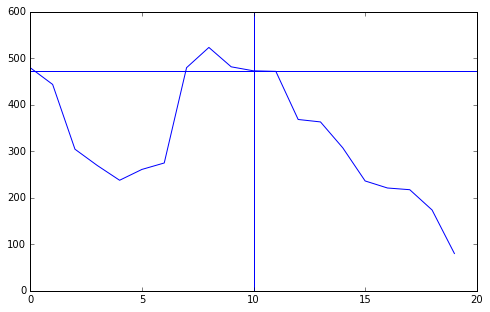

In [77]:
# Plot of the width around the closest point
width_meter = fl.widths * gdir.grid.dx
plt.figure(figsize=(8, 5))
plt.plot(width_meter[index-10:index+10])
plt.axvline(10)
plt.axhline(width_meter[index])
print(width_meter[index])

Ok the the closest point is a good indicator. Let's plot the thickness of our section for several factors:

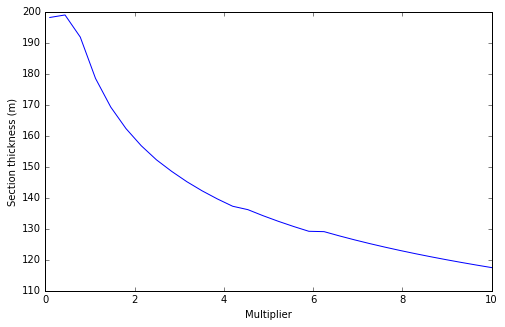

In [78]:
factor = np.linspace(0.1, 10, 30)
thick = factor*0
for i, f in enumerate(factor):
    vol_m3, area_m3 = invert_parabolic_bed(gdir, glen_a=glen_a*f)
    out = gdir.read_pickle('inversion_output', div_id=1)
    thick[i] = out[0]['thick'][index]  
plt.figure(figsize=(8, 5))
plt.plot(factor, thick);
plt.ylabel('Section thickness (m)');
plt.xlabel('Multiplier');

### Flowline modelling 

We are now inverting the ice with a factor 2:

In [30]:
out = invert_parabolic_bed(gdir, glen_a=glen_a*2)

And preparing the data for the run:

In [32]:
flowline.init_present_time_glacier(gdir)

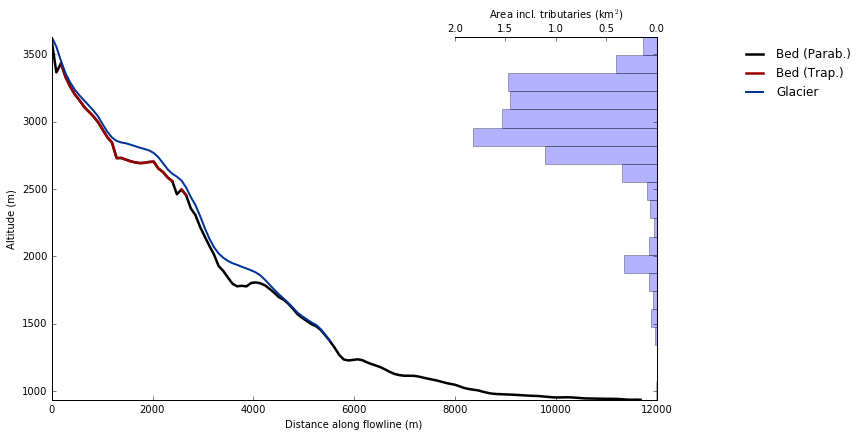

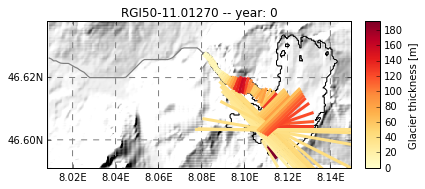

In [33]:
model = flowline.FlowlineModel(gdir.read_pickle('model_flowlines'))
graphics.plot_modeloutput_section(gdir, model=model)
graphics.plot_modeloutput_map(gdir, model=model)

OK, this is definitely going to need for a longer meeting before we go on. But in the mean time you can try to use the "flowline model" part of "getting_started.ipynb" and apply it to Grindelwald, if you want!